# **CIFO Final Project**

## **Student Identification**

**Group 6**

Student Name       | Student Number
-------------------|------------------
Filipe Dias        | r20181050
Inês Santos        | r20191184
Manuel Marreiros   | r20191223

## **Imports**

In [32]:
import numpy as np
import pandas as pd
import tensorflow as tf
import random
import time
from openpyxl import Workbook
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Input, Flatten, Dense
from keras.initializers import GlorotUniform
from matplotlib import pyplot as plt
from PIL import Image
import tensorflow_addons as tfa
from google.colab import files  # Import files module if using Google Colab

## **Data Preprocessing**

In [33]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()


In [34]:
def show_images(images):
    for i in range(min(images.shape[0], 5)):
        img = tf.keras.preprocessing.image.array_to_img(images[i])
        img.show()

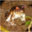

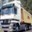

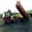

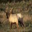

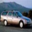

In [35]:
show_images(x_train)

In [36]:
# Preprocess the data
x_train = x_train.reshape(x_train.shape[0], -1)  # Flatten the images into vectors
x_test = x_test.reshape(x_test.shape[0], -1)


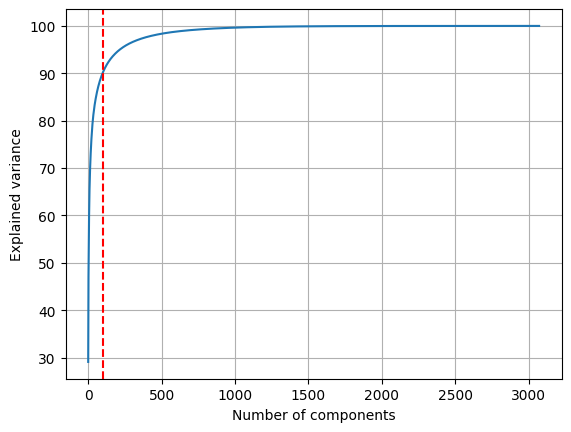

In [38]:
#Perform PCA
pca_3072 = PCA(n_components=3072)
pca_3072.fit(x_train)

#Plot the scree plot
plt.grid()
plt.plot(np.cumsum(pca_3072.explained_variance_ratio_ * 100))
plt.xlabel('Number of components')
plt.ylabel('Explained variance')

#Add a vertical line at 100 components
plt.axvline(x=100, color='r', linestyle='--')
plt.show()

In [39]:
# Apply PCA
pca = PCA(n_components=100)  # Set the desired number of components
x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)

# One-hot encode the labels
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

scaler = StandardScaler()  # Standardize the data
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

## **Utils**

In [6]:
num_classes = 10
num_features = 100

### **Neural Network**

In [7]:
# Defining the single-layer neural network architecture
inputs = Input(shape=(num_features,))
outputs = Dense(num_classes, activation='softmax')(inputs)
model = Model(inputs=inputs, outputs=outputs)

### **Fitness Function**

Although we mainly utilized the first fitness function, where accuracy is the measure of the performance of each individual, we developed a second fitness function, where this measure if the F1-Score. This function was implemented at the end of the project.

In [8]:
# Accuracy Fitness Function
def fitness(chromosome, maximization):
    # Reshape the chromosome to the shape of the NN weights
    # Split the chromosome into weight and bias components
    weights = chromosome.reshape((num_features, num_classes))
    biases = chromosome[-num_classes:]

    model.set_weights([weights, biases])

    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Train the model using the transformed training set
    # model.fit(x_train_pca, y_train, batch_size=32, epochs=3, verbose=0)
    
    # Evaluate the model on the test set and return the accuracy
    loss, accuracy = model.evaluate(x_test_pca.reshape((10000, num_features)), y_test, verbose=0)

    if maximization:
      return accuracy
    else:
      return loss

In [9]:
# F1-Score Fitness Function
def fitness_f1(chromosome, maximization):
    # Reshape the chromosome to the shape of the NN weights
    # Split the chromosome into weight and bias components
    weights = chromosome.reshape((num_features, num_classes))
    biases = chromosome[-num_classes:]

    model.set_weights([weights, biases])

    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[tfa.metrics.F1Score(num_classes=num_classes, average='macro', name='F1_Score')])

    # Evaluate the model on the test set and return  F1-score
    loss, F1_Score = model.evaluate(x_test_pca.reshape((10000, num_features)), y_test, verbose=0)

    if maximization:
      return F1_Score
    else:
      return loss


### **Genetic Operators**

#### **Selection**

In [10]:
# Tournament selection
def tournament_selection(population, maximization, fitness_values, tournament_size):
    # Choose tournament_size individuals at random from the population
    tournament1 = random.sample(list(zip(population, fitness_values)), tournament_size)
    tournament2 = random.sample(list(zip(population, fitness_values)), tournament_size)

    if maximization:
      # Sort the tournament by fitness value in descending order
      tournament1.sort(key=lambda x: x[1], reverse=True)
      tournament2.sort(key=lambda x: x[1], reverse=True)
    else:
      #Sort the tournament by fitness value in ascending order
      tournament1.sort(key=lambda x: x[1], reverse=False)
      tournament2.sort(key=lambda x: x[1], reverse=False)

    # Return the two individuals with the highest fitness values
    return tournament1[0][0], tournament2[0][0]

#Roulette Wheel Selection
def roulette_wheel_selection(population, maximization, fitness_values):
    # calculate the total fitness of the population
    total_fitness = sum(fitness_values)

    # calculate the probability of selection for each individual
    if maximization:
      selection_probabilities = [fitness/total_fitness for fitness in fitness_values]
    else:
      selection_probabilities = [1-fitness/total_fitness for fitness in fitness_values]

    # select two parents using the selection probabilities
    parent_indices = np.random.choice(len(population), size=2, p=selection_probabilities, replace=False)
    parent1 = population[parent_indices[0]]
    parent2 = population[parent_indices[1]]
    return parent1, parent2

#Rank-Tournament Selection
def rank_tournament_selection(population, maximization, fitness_values, tournament_size):
    num_individuals = len(population)
    
    # Rank-based selection
    rank_probabilities = [2 * (i + 1) / (tournament_size * (tournament_size + 1)) for i in range(tournament_size)]
    total_probability = sum(rank_probabilities)

    if maximization:
      rank_selection_probabilities = [p / total_probability for p in rank_probabilities]
    else:
      rank_selection_probabilities = [1 - p / total_probability for p in rank_probabilities]
    
    # Tournament selection
    selected_parents = []
    
    for _ in range(2):  # Select 2 parents
        tournament = random.sample(list(zip(population, fitness_values)), tournament_size)
        
        if random.random() < 0.5:  # 50% chance of using rank-based selection
            selected_parent_index = random.choices(range(tournament_size), weights=rank_selection_probabilities, k=1)[0]
            selected_parent = tournament[selected_parent_index][0]
        else:  # 50% chance of using tournament selection
            if maximization:
              tournament.sort(key=lambda x: x[1], reverse=True)
            else:
              tournament.sort(key=lambda x: x[1], reverse=False)
            selected_parent = tournament[0][0]
        
        selected_parents.append(selected_parent)
    
    return selected_parents

#### **Crossover**

In [11]:
# Single-point crossover
def single_point_crossover(parent1, parent2):
    co_point = np.random.randint(1, len(parent1)-2)

    child1 = np.concatenate((parent1[:co_point], parent2[co_point:]))
    child2 = np.concatenate((parent2[:co_point], parent1[co_point:]))

    return child1, child2

# Uniform crossover
def uniform_crossover(parent1, parent2): 
    child1 = []
    child2 = []
    
    # Iterate over the genes in the parents
    for gene1, gene2 in zip(parent1, parent2):
        # Randomly select which gene to use for child1 and child2
        if random.random() < 0.5:
            child1.append(gene1)
            child2.append(gene2)
        else:
            child1.append(gene2)
            child2.append(gene1)
    
    return child1, child2

# Arithmetric crossover
def arithmetic_crossover(parent1, parent2):
    # Child placeholders
    child1 = []
    child2 = []

    # Set a value for alpha between 0 and 1
    alpha = random.uniform(0, 1)

    for i in range(len(parent1)):
        child1.append(np.round(parent1[i] * alpha + (1 - alpha) * parent2[i], 2))
        child2.append(np.round(parent2[i] * alpha + (1 - alpha) * parent1[i], 2))

    return child1, child2

#Double-point crossover
def double_point_crossover(parent1, parent2):
    # Generate two random crossover points
    point1 = random.randint(0, len(parent1)-1)
    point2 = random.randint(0, len(parent1)-1)
    
    # Make sure point1 is less than point2
    if point1 > point2:
        point1, point2 = point2, point1
    
    # Perform crossover
    child1 = np.concatenate((parent1[:point1], parent2[point1:point2], parent1[point2:]))
    child2 = np.concatenate((parent2[:point1], parent1[point1:point2], parent2[point2:]))
    
    return child1, child2


#### **Mutation**

In [12]:
# Gaussian mutation
def gaussian_mutation(chromosome):
    idx = np.random.randint(0, len(chromosome))
    chromosome[idx] += np.random.normal(0, 1)
    return chromosome

# Gaussian mutation 2
def gaussian_mutation_2(chromosome, mut_rt):
    mutated_chromosome = chromosome.copy()
    num_genes = len(chromosome)

    for i in range(num_genes):
        if np.random.uniform() < mut_rt:
            mutated_chromosome[i] += np.random.normal(0, 1)

    return mutated_chromosome

# Swap mutation
def swap_mutation(chromosome):
    mutated_chromosome = chromosome
    idx1, idx2 = np.random.choice(len(chromosome), size=2, replace=False)
    mutated_chromosome[idx1], mutated_chromosome[idx2] = mutated_chromosome[idx2], mutated_chromosome[idx1]
    return mutated_chromosome

# Inversion Mutation
def inversion_mutation(chromosome):
    mutated_chromosome = chromosome.copy()
    idx1, idx2 = np.random.choice(len(chromosome), size=2, replace=False)

    if idx1 > idx2: #the second points must be after the first one
        idx1, idx2 = idx2, idx1
    
    mutated_chromosome[idx1:idx2] = mutated_chromosome[idx1:idx2][::-1]

    return mutated_chromosome

#### **Elitism**

In [19]:
def elitism_func(population, maximization, fitness_values, elite_size):
    if maximization:
      elite_indices = np.argsort(fitness_values)[::-1][:elite_size]
    else:
      elite_indices = np.argsort(fitness_values)[:elite_size]

    elite_population = population[elite_indices]
    
    return elite_population

#### **Initialization**

In [14]:
# Xavier initialization function
def xavier_init(shape):
    fan_in = shape[0]
    fan_out = shape[1]
    limit = np.sqrt(6 / (fan_in + fan_out))
    return np.random.uniform(low=-limit, high=limit, size=shape)

## **Genetic Algorithms**

We first define a function for our genetic algorithm. This function takes the following arguments:

1.   Population
2.   If it is a maximization problem
3.   Fitness function
4.   Selection, crossover and mutation methods
5.   If there is elitism
6.   Number of generations
7.   Crossover and mutation rates
8.   The size of the elite population (the default is 0)
9.   Additional arguments that may be required

This way, we are able to easily test how different combinations of genetic operators and parameters may affect our results.

In [27]:
def genetic_algorithm(population, maximization, fitness, selection, crossover, mutation, elitism, num_generations, crossover_rate, mutation_rate, elite_size=0, **kwargs):
  # This dictionary will store the metrics we will use to evaluate the models
  final_results = {}

  # This array will store the best fitness registered in each generation
  results = []

  # This array will register how each generation improved compared to the previous one
  improvements = []

  # This variable will store the time when the algorithm started running
  start_time = time.time()

  for i in range(num_generations):
      next_generation = []
      elite_population = []

      # Evaluate the fitness of each chromosome in the population
      fitness_values = np.array([fitness(chromosome, maximization) for chromosome in population])

      if elitism:
        elite_population = elitism_func(population, maximization, fitness_values, elite_size)
      
      # Populate the next generation using crossover and mutation
      for j in range(pop_size - elite_size):
        
          parent1, parent2 = selection(population, maximization, fitness_values, **kwargs.get('selection_args', {}))

          if np.random.rand() < crossover_rate:
              child1, child2 = crossover(parent1, parent2)
          else:
              child1, child2 = parent1, parent2

          if np.random.rand() < mutation_rate:
                child1 = mutation(child1, **kwargs.get('mutation_args', {}))
          if np.random.rand() < mutation_rate:
                child2 = mutation(child2, **kwargs.get('mutation_args', {}))

          next_generation.append(child1)
                
          if len(next_generation) < len(population):
              next_generation.append(child2)

      if elitism:
        next_generation.extend(elite_population)

      population = np.array(next_generation)
      
      if maximization:

        best_fitness = np.max(fitness_values)
        results.append(best_fitness)
        print("Generation {}: Best fitness = {:.4f}".format(i+1, best_fitness))

        # Compute the improvement rate of the current generation
        if i > 0:
          prev_best_fitness = results[-2]
          improvement = (best_fitness - prev_best_fitness) / prev_best_fitness
          improvements.append(improvement)

      else:
        worst_fitness = np.min(fitness_values)
        results.append(worst_fitness)
        print("Generation {}: Worst fitness = {:.4f}".format(i+1, worst_fitness))

        # Compute the improvement rate of the current generation
        if i > 0:
          prev_worst_fitness = results[-2]
          improvement = (prev_worst_fitness - worst_fitness) / worst_fitness
          improvements.append(improvement)

  best_chromosome = []
  best_fitness = 0
  convergence_index = 0

  if maximization:
    # Select the best chromosome as the final solution
    best_chromosome = population[np.argmax(results)]

    # The highest value registered
    best_fitness = np.max(results)

    # Find the index where the best fitness value reaches a certain threshold
    threshold = 0.99 * np.max(results)  # Convergende threshold
    convergence_index = next((i for i, fitness in enumerate(results) if fitness >= threshold), None)

  else:
    # Select the best chromosome as the final solution
    best_chromosome = population[np.argmin(results)]

    # The lowest value registered
    best_fitness = np.min(results)

    # Find the index where the fitness value falls below or reaches the threshold
    threshold = 1.01 * np.min(results)  # Convergence threshold
    convergence_index = next((i for i, fitness in enumerate(results) if fitness <= threshold), None)

  # Build the NN model with the best weights
  best_weights = best_chromosome.reshape((num_features, num_classes))

  # Record the results for this run
  final_results = {
        'best_fitness': best_fitness,
        'convergence_rate': (convergence_index + 1) / num_generations * 100,
        'run_time': time.time() - start_time,
        'best_weights': ', '.join(str(value) for value in best_weights),
        'avg_improvement_rate': np.average(improvements)
  }

  results = ', '.join(str(value) for value in results)

  return final_results, results


Additionally, we define the first set of parameters with which we will initially test the different genetic algorithms.

In [16]:
# Initialize the GA parameters
pop_size = 30
num_generations = 15
mutation_rate = 0.08
crossover_rate = 0.8
elite_size = 3

For the purpose of our work, we will run each combination of genetic operators 5 times, since we are dealing with a certain degree of randomization. For each run, we will evaluate the algorithm based on the **best fitness value**, **convergence rate**, **diversity of the final population**, **computational efficiency**, and **improvement rate**. These results are then saved to an external excel sheet so that we can further analyze them. 

In [17]:
num_iterations = 3

### **GA1**

This first algorithm implements **Tournament Selection**, **Uniform Crossover**, and **Gaussian Mutation**.

In [ ]:
GA1_results = []

for i in range(num_iterations):

  # Initialize the population of candidate solutions using Xavier initialization
  population = xavier_init((pop_size, num_features, num_classes)).reshape((pop_size, num_features*num_classes))

  print("----- Run", i+1, "-----")
  print()

  GA1 = genetic_algorithm(population=population,
                          maximization=True,
                          fitness=fitness, 
                          selection=tournament_selection,
                          crossover=uniform_crossover, 
                          mutation=gaussian_mutation, 
                          elitism=True, 
                          num_generations=num_generations, 
                          crossover_rate=crossover_rate, 
                          mutation_rate=mutation_rate,  
                          elite_size=elite_size,
                          selection_args={"tournament_size":5})

  print()

  GA1_results.append({
        'run': i+1,
        'best_fitness': GA1[0]['best_fitness'],
        'convergence_rate': GA1[0]['convergence_rate'],
        'run_time': GA1[0]['run_time'],
        'best_weights': GA1[0]['best_weights'],
        'avg_improvement_rate': GA1[0]['avg_improvement_rate'],
        'results': GA1[1]
  })
  

NameError: ignored

In [ ]:
# Convert the results to a pandas DataFrame
df = pd.DataFrame.from_dict(GA1_results)

# Create a new Excel file
workbook = Workbook()

# Select the active worksheet
worksheet = workbook.active

# Set the title of the worksheet
worksheet.title = 'GA1 Results'

# Convert the DataFrame to a list of lists
data = df.values.tolist()

# Write the header row to the worksheet
header = df.columns.tolist()
worksheet.append(header)

# Write the DataFrame to the worksheet
for r in data:
    worksheet.append(r)

# Save the Excel file
workbook.save('GA Results.xlsx')

### **GA2**

Our results seemed satisfactory, but we had nothing to which we could compare them. Here we completely switched gears and changed all three genetic parameters, implementing **Roulette Wheel Selection**, **Arithmetic Crossover**, and **Swap Mutation**.

In [ ]:
GA2_results = []

for i in range(num_iterations):

  # Initialize the population of candidate solutions using Xavier initialization
  population = xavier_init((pop_size, num_features, num_classes)).reshape((pop_size, num_features*num_classes))

  print("----- Run", i+1, "-----")
  print()

  GA2 = genetic_algorithm(population=population,
                          maximization=True,
                          fitness=fitness,  
                          selection=roulette_wheel_selection, 
                          crossover=arithmetic_crossover, 
                          mutation=swap_mutation, 
                          elitism=True, 
                          num_generations=num_generations, 
                          crossover_rate=crossover_rate, 
                          mutation_rate=mutation_rate, 
                          elite_size=elite_size)
  
  print()

  GA2_results.append({
        'run': i+1,
        'best_fitness': GA2[0]['best_fitness'],
        'convergence_rate': GA2[0]['convergence_rate'],
        'run_time': GA2[0]['run_time'],
        'best_weights': GA2[0]['best_weights'],
        'avg_improvement_rate': GA2[0]['avg_improvement_rate'],
        'results': GA2[1]
  })

In [ ]:
# Convert the results to a pandas DataFrame
df2 = pd.DataFrame.from_dict(GA2_results)

# Create a new Excel file
workbook = Workbook()

# Select the active worksheet
worksheet = workbook.active

# Set the title of the worksheet
worksheet.title = 'GA2 Results'

# Convert the DataFrame to a list of lists
data = df2.values.tolist()

# Write the header row to the worksheet
header = df2.columns.tolist()
worksheet.append(header)

# Write the DataFrame to the worksheet
for r in data:
    worksheet.append(r)

# Save the Excel file
workbook.save('GA2 Results.xlsx')

### **GA3**

Our algorithm seemed to prematurely converge and get stuck on a local optimum. We thought this might have been to roulette wheel selection, so here we implemented **Tournament Selection**, **Arithmetic Crossover**, and **Swap Mutation**.

In [ ]:
GA3_results = []

for i in range(num_iterations):

  # Initialize the population of candidate solutions using Xavier initialization
  population = xavier_init((pop_size, num_features, num_classes)).reshape((pop_size, num_features*num_classes))

  print("----- Run", i+1, "-----")
  print()

  GA3 = genetic_algorithm(population=population,
                          maximization=True, 
                          fitness=fitness, 
                          selection=tournament_selection,
                          crossover=arithmetic_crossover, 
                          mutation=swap_mutation, 
                          elitism=True, 
                          num_generations=num_generations, 
                          crossover_rate=crossover_rate, 
                          mutation_rate=mutation_rate,  
                          elite_size=elite_size,
                          selection_args={"tournament_size":5})

  print()

  GA3_results.append({
        'run': i+1,
        'best_fitness': GA3[0]['best_fitness'],
        'convergence_rate': GA3[0]['convergence_rate'],
        'run_time': GA3[0]['run_time'],
        'best_weights': GA3[0]['best_weights'],
        'avg_improvement_rate': GA3[0]['avg_improvement_rate'],
        'results': GA3[1]
  })
  

In [ ]:
# Convert the results to a pandas DataFrame
df3 = pd.DataFrame.from_dict(GA3_results)

# Create a new Excel file
workbook = Workbook()

# Select the active worksheet
worksheet = workbook.active

# Set the title of the worksheet
worksheet.title = 'GA3 Results'

# Convert the DataFrame to a list of lists
data = df3.values.tolist()

# Write the header row to the worksheet
header = df3.columns.tolist()
worksheet.append(header)

# Write the DataFrame to the worksheet
for r in data:
    worksheet.append(r)

# Save the Excel file
workbook.save('GA3 Results.xlsx')

### **GA4**

While not getting stuck on local optima, the results did not show great signs of improvement either. Thus, we decided to implement a more agressive mutation method, combining **Tournament Selection**, **Arithmetic Crossover**, and **Inversion Mutation**.

In [ ]:
GA4_results = []

for i in range(num_iterations):

  # Initialize the population of candidate solutions using Xavier initialization
  population = xavier_init((pop_size, num_features, num_classes)).reshape((pop_size, num_features*num_classes))

  print("----- Run", i+1, "-----")
  print()

  GA4 = genetic_algorithm(population=population,
                          maximization=True,
                          fitness=fitness,  
                          selection=tournament_selection,
                          crossover=arithmetic_crossover, 
                          mutation=inversion_mutation, 
                          elitism=True, 
                          num_generations=num_generations, 
                          crossover_rate=crossover_rate, 
                          mutation_rate=mutation_rate,  
                          elite_size=elite_size,
                          selection_args={"tournament_size":5})

  print()

  GA4_results.append({
        'run': i+1,
        'best_fitness': GA4[0]['best_fitness'],
        'convergence_rate': GA4[0]['convergence_rate'],
        'run_time': GA4[0]['run_time'],
        'best_weights': GA4[0]['best_weights'],
        'avg_improvement_rate': GA4[0]['avg_improvement_rate'],
        'results': GA4[1]
  })
  

In [ ]:
# Convert the results to a pandas DataFrame
df4 = pd.DataFrame.from_dict(GA4_results)

# Create a new Excel file
workbook = Workbook()

# Select the active worksheet
worksheet = workbook.active

# Set the title of the worksheet
worksheet.title = 'GA4 Results'

# Convert the DataFrame to a list of lists
data = df4.values.tolist()

# Write the header row to the worksheet
header = df4.columns.tolist()
worksheet.append(header)

# Write the DataFrame to the worksheet
for r in data:
    worksheet.append(r)

# Save the Excel file
workbook.save('GA4 Results.xlsx')

### **GA5**

We still weren't getting results neraly as good as with our first combination. Nonetheless, we wanted to experiment with other unused operators. The fifth algorithm implements **Tournament Selection**, **Single-Point Crossover**, and **Inversion Mutation**.

In [ ]:
GA5_results = []

for i in range(num_iterations):

  # Initialize the population of candidate solutions using Xavier initialization
  population = xavier_init((pop_size, num_features, num_classes)).reshape((pop_size, num_features*num_classes))

  print("----- Run", i+1, "-----")
  print()

  GA5 = genetic_algorithm(population=population,
                          maximization=True, 
                          fitness=fitness, 
                          selection=tournament_selection,
                          crossover=single_point_crossover, 
                          mutation=inversion_mutation, 
                          elitism=True, 
                          num_generations=num_generations, 
                          crossover_rate=crossover_rate, 
                          mutation_rate=mutation_rate,  
                          elite_size=elite_size,
                          selection_args={"tournament_size":5})

  print()

  GA5_results.append({
        'run': i+1,
        'best_fitness': GA5[0]['best_fitness'],
        'convergence_rate': GA5[0]['convergence_rate'],
        'run_time': GA5[0]['run_time'],
        'best_weights': GA5[0]['best_weights'],
        'avg_improvement_rate': GA5[0]['avg_improvement_rate'],
        'results': GA5[1]
  })
  

In [ ]:
# Convert the results to a pandas DataFrame
df5 = pd.DataFrame.from_dict(GA5_results)

# Create a new Excel file
workbook = Workbook()

# Select the active worksheet
worksheet = workbook.active

# Set the title of the worksheet
worksheet.title = 'GA5 Results'

# Convert the DataFrame to a list of lists
data = df5.values.tolist()

# Write the header row to the worksheet
header = df5.columns.tolist()
worksheet.append(header)

# Write the DataFrame to the worksheet
for r in data:
    worksheet.append(r)

# Save the Excel file
workbook.save('GA5 Results.xlsx')

### **GA6**

Up until this point, we mainly implemented tournament selection. So what if we went back to the GA1 combination, but switched the selection method? GA6 combines **Roulette Wheel Selection**, **Uniform Crossover**, and **Gaussian Mutation**.

In [ ]:
GA6_results = []

for i in range(num_iterations):

  # Initialize the population of candidate solutions using Xavier initialization
  population = xavier_init((pop_size, num_features, num_classes)).reshape((pop_size, num_features*num_classes))

  print("----- Run", i+1, "-----")
  print()

  GA6 = genetic_algorithm(population=population,
                          maximization=True, 
                          fitness=fitness, 
                          selection=roulette_wheel_selection,
                          crossover=uniform_crossover, 
                          mutation=gaussian_mutation, 
                          elitism=True, 
                          num_generations=num_generations, 
                          crossover_rate=crossover_rate, 
                          mutation_rate=mutation_rate,  
                          elite_size=elite_size)

  print()

  GA6_results.append({
        'run': i+1,
        'best_fitness': GA6[0]['best_fitness'],
        'convergence_rate': GA6[0]['convergence_rate'],
        'run_time': GA6[0]['run_time'],
        'best_weights': GA6[0]['best_weights'],
        'avg_improvement_rate': GA6[0]['avg_improvement_rate'],
        'results': GA6[1]
  })
  

In [ ]:
# Convert the results to a pandas DataFrame
df6 = pd.DataFrame.from_dict(GA6_results)

# Create a new Excel file
workbook = Workbook()

# Select the active worksheet
worksheet = workbook.active

# Set the title of the worksheet
worksheet.title = 'GA6 Results'

# Convert the DataFrame to a list of lists
data = df6.values.tolist()

# Write the header row to the worksheet
header = df6.columns.tolist()
worksheet.append(header)

# Write the DataFrame to the worksheet
for r in data:
    worksheet.append(r)

# Save the Excel file
workbook.save('GA6 Results.xlsx')

### **GA7**

Because our first implementation was generating unquestionably better results, for the seventh algorithm we went back to utilizing **Tournament Selection**, **Uniform Crossover**, and **Gaussian Mutation**, but with a slight twist. When mutating a chromosome, rather than mutating just one single gene at random, we iterated through the whole chromosome and transformed multiple genes. We called this function *gaussian_mutation_2*.

In [ ]:
GA7_results = []

for i in range(num_iterations):

  # Initialize the population of candidate solutions using Xavier initialization
  population = xavier_init((pop_size, num_features, num_classes)).reshape((pop_size, num_features*num_classes))

  print("----- Run", i+1, "-----")
  print()

  GA7 = genetic_algorithm(population=population, 
                          maximization=True,
                          fitness=fitness, 
                          selection=tournament_selection,
                          crossover=uniform_crossover, 
                          mutation=gaussian_mutation_2, 
                          elitism=True, 
                          num_generations=num_generations, 
                          crossover_rate=crossover_rate, 
                          mutation_rate=mutation_rate,  
                          elite_size=elite_size,
                          selection_args={"tournament_size":5},
                          mutation_args={"mut_rt":0.8})

  print()

  GA7_results.append({
        'run': i+1,
        'best_fitness': GA7[0]['best_fitness'],
        'convergence_rate': GA7[0]['convergence_rate'],
        'run_time': GA7[0]['run_time'],
        'best_weights': GA7[0]['best_weights'],
        'avg_improvement_rate': GA7[0]['avg_improvement_rate'],
        'results': GA7[1]
  })
  

In [ ]:
# Convert the results to a pandas DataFrame
df7 = pd.DataFrame.from_dict(GA7_results)

# Create a new Excel file
workbook = Workbook()

# Select the active worksheet
worksheet = workbook.active

# Set the title of the worksheet
worksheet.title = 'GA7 Results'

# Convert the DataFrame to a list of lists
data = df7.values.tolist()

# Write the header row to the worksheet
header = df7.columns.tolist()
worksheet.append(header)

# Write the DataFrame to the worksheet
for r in data:
    worksheet.append(r)

# Save the Excel file
workbook.save('GA7 Results.xlsx')

### **GA8**

While the results were very similar to GA1's, we still wanted an algorithm that could perform better. GA8 implements a combination of rank-based selection and tournament selection, called **Rank-Tournament Selection**. We sought to both explore and exploit our solutions, switching between both selection methods throughout the algorithm. This method was combined with **Uniform Crossover** and **Gaussian Mutation 2**. Furthermore, we raised our **crossover rate to 0.9** and **mutation rate to 0.1**, to increase exploration.

In [ ]:
GA8_results = []

for i in range(num_iterations):

  # Initialize the population of candidate solutions using Xavier initialization
  population = xavier_init((pop_size, num_features, num_classes)).reshape((pop_size, num_features*num_classes))

  print("----- Run", i+1, "-----")
  print()

  GA8 = genetic_algorithm(population=population, 
                          maximization=True,
                          fitness=fitness, 
                          selection=rank_tournament_selection,
                          crossover=uniform_crossover, 
                          mutation=gaussian_mutation_2, 
                          elitism=True, 
                          num_generations=num_generations, 
                          crossover_rate=0.9, 
                          mutation_rate=0.1,  
                          elite_size=elite_size,
                          selection_args={"tournament_size":5},
                          mutation_args={"mut_rt":0.8})

  print()

  GA8_results.append({
        'run': i+1,
        'best_fitness': GA8[0]['best_fitness'],
        'convergence_rate': GA8[0]['convergence_rate'],
        'run_time': GA8[0]['run_time'],
        'best_weights': GA8[0]['best_weights'],
        'avg_improvement_rate': GA8[0]['avg_improvement_rate'],
        'results': GA8[1]
  })
  

In [ ]:
# Convert the results to a pandas DataFrame
df8 = pd.DataFrame.from_dict(GA8_results)

# Create a new Excel file
workbook = Workbook()

# Select the active worksheet
worksheet = workbook.active

# Set the title of the worksheet
worksheet.title = 'GA8 Results'

# Convert the DataFrame to a list of lists
data = df8.values.tolist()

# Write the header row to the worksheet
header = df8.columns.tolist()
worksheet.append(header)

# Write the DataFrame to the worksheet
for r in data:
    worksheet.append(r)

# Save the Excel file
workbook.save('GA8 Results.xlsx')

### **GA9**

Still not obtaining better results, we wanted to do one last experiment, utilizing a completely new operator. GA9 implements **Rank-Tournament Selection**, **Double-Point Crossover**, and **Gaussian Mutation 2**. The hyperparameter values were the same as in GA8.

In [ ]:
GA9_results = []

for i in range(num_iterations):

  # Initialize the population of candidate solutions using Xavier initialization
  population = xavier_init((pop_size, num_features, num_classes)).reshape((pop_size, num_features*num_classes))

  print("----- Run", i+1, "-----")
  print()

  GA9 = genetic_algorithm(population=population, 
                          maximization=True,
                          fitness=fitness, 
                          selection=rank_tournament_selection,
                          crossover=double_point_crossover, 
                          mutation=gaussian_mutation_2, 
                          elitism=True, 
                          num_generations=num_generations, 
                          crossover_rate=0.9, 
                          mutation_rate=0.1,  
                          elite_size=elite_size,
                          selection_args={"tournament_size":5},
                          mutation_args={"mut_rt":0.8})

  print()

  GA9_results.append({
        'run': i+1,
        'best_fitness': GA9[0]['best_fitness'],
        'convergence_rate': GA9[0]['convergence_rate'],
        'run_time': GA9[0]['run_time'],
        'best_weights': GA9[0]['best_weights'],
        'avg_improvement_rate': GA9[0]['avg_improvement_rate'],
        'results': GA9[1]
  })

In [ ]:
# Convert the results to a pandas DataFrame
df9 = pd.DataFrame.from_dict(GA9_results)

# Create a new Excel file
workbook = Workbook()

# Select the active worksheet
worksheet = workbook.active

# Set the title of the worksheet
worksheet.title = 'GA9 Results'

# Convert the DataFrame to a list of lists
data = df9.values.tolist()

# Write the header row to the worksheet
header = df9.columns.tolist()
worksheet.append(header)

# Write the DataFrame to the worksheet
for r in data:
    worksheet.append(r)

# Save the Excel file
workbook.save('GA9 Results.xlsx')

## **Particle Swarm Optimization**

As an addition to our project, we decided to implement **Particle Swarm Optimization**. Some advantages of applying PSO rather than a GA to this type of problem would be the former's tendency to **converge faster to optimal solutions**, without getting stuck in a local optimum. Additionally, it is efficient, requiring **less parameter tuning**, and it is adequate for **continuous optimization**.

In [ ]:
num_particles = 30
num_generations = 15
inertia_weight = 0.9
cognitive_weight = 0.5
social_weight = 0.5


In [ ]:
def particle_swarm_optimization(particles, num_particles, num_generations, inertia_weight, cognitive_weight, social_weight):
    
    # This dictionary will store the metrics we will use to evaluate the models
    final_results = {}

    # This array will store the best fitness registered in each generation
    results = []

    # This array will register how each generation improved compared to the previous one
    improvements = []
    
    # Initialize the particles
    velocities = np.zeros_like(particles) #initializes the velocities of the particles as an array of zeros, with the same shape as the particles array
    best_positions = particles.copy()
    best_fitnesses = np.zeros(num_particles) #initializes an array of zeros with a length equal to the number of particles. 

    global_best_position = best_positions[0].copy()
    global_best_fitness = float('inf')

    # Run the iterations
    global_best_index = 0
    start_time = time.time()
    for iteration in range(num_generations):
        for i in range(num_particles): #nested loop that iterates over each particle in the swarm.
            particle = particles[i]
            velocity = velocities[i]
            # Update the particle velocity
            new_velocity = (
                inertia_weight * velocity +
                cognitive_weight * np.random.rand() * (best_positions[i] - particle) + #cognitive component, considers the personal best
                social_weight * np.random.rand() * (best_positions[global_best_index] - particle) #social component, considers the global best
            )
            velocities[i] = new_velocity

            # Update the particle position
            new_particle = particle + new_velocity
            particles[i] = new_particle

            # Evaluate the fitness of each particle in the population
            particle_fitness = fitness(new_particle)

            if particle_fitness > best_fitnesses[i]: #updating local best
                best_positions[i] = new_particle
                best_fitnesses[i] = particle_fitness

                # Update the global best index
                if particle_fitness > best_fitnesses[global_best_index]:
                    global_best_index = i

        # Print the best fitness value in the current iteration
        global_best_fitness = best_fitnesses[global_best_index]
        results.append(global_best_fitness)
        print("Iteration {}: Best fitness = {:.4f}".format(iteration + 1, global_best_fitness))

        # Compute the improvement rate of the current generation
        if iteration > 0:
          prev_best_fitness = results[-2]
          improvement = (global_best_fitness - prev_best_fitness) / prev_best_fitness
          improvements.append(improvement)
    
    # Record the results for this run
    run_time = time.time() - start_time
    best_weights = best_positions[global_best_index]
    
    # Find the index where the best fitness value reaches a certain threshold
    threshold = 0.99 * np.max(results)  # Convergende threshold
    convergence_index = next((i for i, fitness in enumerate(results) if fitness >= threshold), None)
    
    final_results = {
        'best_fitness': global_best_fitness,
        'convergence_rate': (convergence_index + 1) / num_generations * 100,
        'run_time': run_time,
        'best_weights': best_weights,
        'avg_improvement_rate': np.average(improvements)
    }

    results = ', '.join(str(value) for value in results)

    return final_results, results

In [ ]:
PS_results = []

for i in range(num_iterations):

  # Initialize the population of candidate solutions using Xavier initialization
  particles = xavier_init((pop_size, num_features, num_classes)).reshape((pop_size, num_features*num_classes))

  print("----- Run", i+1, "-----")
  print()

  PS = particle_swarm_optimization(particles=particles, 
                                 num_particles=num_particles, 
                                 num_generations=num_generations, 
                                 inertia_weight=inertia_weight,
                                 cognitive_weight=cognitive_weight, 
                                 social_weight=social_weight)

  print()

  PS_results.append({
        'run': i+1,
        'best_fitness': PS[0]['best_fitness'],
        'convergence_rate': PS[0]['convergence_rate'],
        'run_time': PS[0]['run_time'],
        'best_weights': PS[0]['best_weights'],
        'avg_improvement_rate': PS[0]['avg_improvement_rate'],
        'results':PS[1]
    })

----- Run 1 -----

Iteration 1: Best fitness = 0.1422
Iteration 2: Best fitness = 0.1508
Iteration 3: Best fitness = 0.1528
Iteration 4: Best fitness = 0.1610
Iteration 5: Best fitness = 0.1679
Iteration 6: Best fitness = 0.1741
Iteration 7: Best fitness = 0.1806
Iteration 8: Best fitness = 0.1906
Iteration 9: Best fitness = 0.1941
Iteration 10: Best fitness = 0.1958
Iteration 11: Best fitness = 0.2033
Iteration 12: Best fitness = 0.2034
Iteration 13: Best fitness = 0.2059
Iteration 14: Best fitness = 0.2059
Iteration 15: Best fitness = 0.2069

----- Run 2 -----

Iteration 1: Best fitness = 0.1358
Iteration 2: Best fitness = 0.1456
Iteration 3: Best fitness = 0.1498
Iteration 4: Best fitness = 0.1542
Iteration 5: Best fitness = 0.1610
Iteration 6: Best fitness = 0.1705
Iteration 7: Best fitness = 0.1751
Iteration 8: Best fitness = 0.1772
Iteration 9: Best fitness = 0.1876
Iteration 10: Best fitness = 0.1903
Iteration 11: Best fitness = 0.1936
Iteration 12: Best fitness = 0.1978
Iterati

In [ ]:
# Convert the results to a pandas DataFrame
df10 = pd.DataFrame.from_dict(PS_results)

df10['best_weights'] = df10['best_weights'].apply(lambda x: ', '.join(str(value) for value in x))

# Create a new Excel file
workbook = Workbook()

# Select the active worksheet
worksheet = workbook.active

# Set the title of the worksheet
worksheet.title = 'PS Results'

# Convert the DataFrame to a list of lists
data = df10.values.tolist()

# Write the header row to the worksheet
header = df10.columns.tolist()
worksheet.append(header)

# Write the DataFrame to the worksheet
for r in data:
    worksheet.append(r)

# Save the Excel file
workbook.save('PS Results.xlsx')

from google.colab import files
files.download('PS Results.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Results**

### **Plot comparison against iterations (Average Best Fitness)**

Saving Results_Geral.xlsx to Results_Geral.xlsx


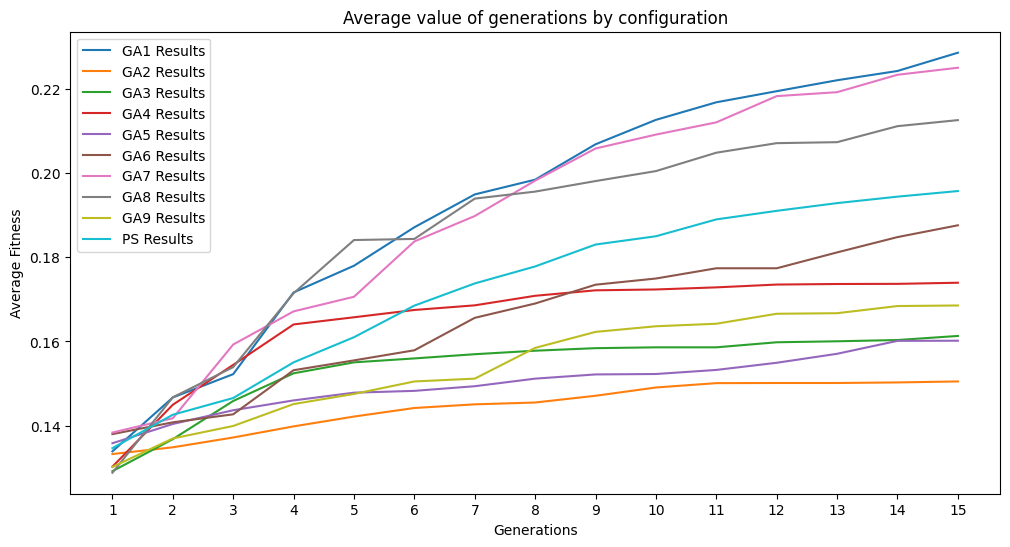

In [ ]:
def plot_means_from_excel(sheet_names):
    # Upload Excel file
    uploaded = files.upload()
    file_name = list(uploaded.keys())[0]

    # Read data from Excel file for each sheet
    average_dfs = []
    for sheet_name in sheet_names:
        GA1_results = pd.read_excel(file_name, sheet_name=sheet_name)

        # Split the 'results' column values and create separate columns
        results_df = pd.DataFrame(GA1_results['results'].str.split(',').tolist(), dtype=float)
        
        # Calculate the average of each column
        average_values = results_df.mean(axis=0)

        # Create a DataFrame to store average values and their column indices
        averages_df = pd.DataFrame({'Column': range(1, len(average_values) + 1), 'Average': average_values})

        average_dfs.append(averages_df)
  
    # Plot the average values for each sheet
    plt.figure(figsize=(12, 6))
    for averages_df in average_dfs:
        plt.plot(averages_df['Column'], averages_df['Average'])

    plt.xlabel('Generations')
    plt.ylabel('Average Fitness')
    plt.title('Average value of generations by configuration')
    plt.legend(sheet_names)
    plt.xticks(range(1, len(average_values) + 1), range(1, len(average_values) + 1))
    plt.show()
    
    
# Example usage:

sheet_names = ['GA1 Results', 'GA2 Results', 'GA3 Results', 'GA4 Results', 'GA5 Results', 'GA6 Results', 'GA7 Results', 'GA8 Results', 'GA9 Results', 'PS Results']  # List of sheet names containing the data
plot_means_from_excel(sheet_names)


Saving Results_Geral.xlsx to Results_Geral (1).xlsx


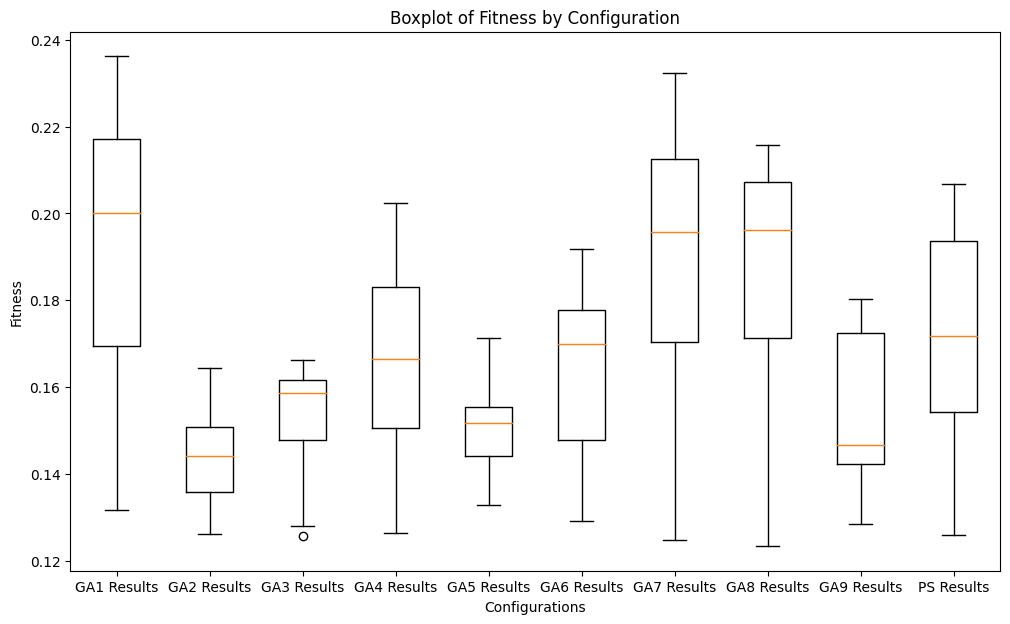

In [ ]:
def plot_means_from_excel(sheet_names):
    # Upload Excel file
    uploaded = files.upload()
    file_name = list(uploaded.keys())[0]

    # Read data from Excel file for each sheet
    data = []
    for sheet_name in sheet_names:
        GA_results = pd.read_excel(file_name, sheet_name=sheet_name)

        # Split the 'results' column values and create separate columns
        results_df = pd.DataFrame(GA_results['results'].str.split(',').tolist(), dtype=float)
        data.append(results_df.values.flatten())  # Flatten the data to 1D
        
    # Generate boxplots for each generation
    plt.figure(figsize=(12, 7))
    plt.boxplot(data)
    plt.xlabel('Configurations')
    plt.ylabel('Fitness')
    plt.title('Boxplot of Fitness by Configuration')
    plt.xticks(range(1, len(sheet_names) + 1), sheet_names)
    plt.show()

# Example usage:
sheet_names = ['GA1 Results', 'GA2 Results', 'GA3 Results', 'GA4 Results', 'GA5 Results', 'GA6 Results', 'GA7 Results', 'GA8 Results', 'GA9 Results', 'PS Results']  # List of sheet names containing the data
plot_means_from_excel(sheet_names)



## **Final Tests**

### **Testing with 30 Generations**

Since our GA1 implementation was the one that presented better results, having a convergence rate of 100%, meaning it was improving significantly throughout all 15 generations, we wanted to take it further. Here, we implement GA1 with 30 generations.

In [ ]:
GA1_final_results = []

for i in range(num_iterations):

  # Initialize the population of candidate solutions using Xavier initialization
  population = xavier_init((pop_size, num_features, num_classes)).reshape((pop_size, num_features*num_classes))

  print("----- Run", i+1, "-----")
  print()

  GA1_1 = genetic_algorithm(population=population,
                            maximization=True,
                            fitness=fitness,
                            selection=tournament_selection,
                            crossover=uniform_crossover, 
                            mutation=gaussian_mutation, 
                            elitism=True, 
                            num_generations=30, 
                            crossover_rate=crossover_rate, 
                            mutation_rate=mutation_rate,  
                            elite_size=elite_size,
                            selection_args={"tournament_size":5})

  print()

  GA1_final_results.append({
        'run': i+1,
        'best_fitness': GA1_1[0]['best_fitness'],
        'convergence_rate': GA1_1[0]['convergence_rate'],
        'run_time': GA1_1[0]['run_time'],
        'best_weights': GA1_1[0]['best_weights'],
        'avg_improvement_rate': GA1_1[0]['avg_improvement_rate'],
        'results': GA1_1[1]
  })

----- Run 1 -----

Generation 1: Best fitness = 0.1341
Generation 2: Best fitness = 0.1438
Generation 3: Best fitness = 0.1547
Generation 4: Best fitness = 0.1621
Generation 5: Best fitness = 0.1697
Generation 6: Best fitness = 0.1802
Generation 7: Best fitness = 0.1852
Generation 8: Best fitness = 0.1907
Generation 9: Best fitness = 0.1979
Generation 10: Best fitness = 0.2034
Generation 11: Best fitness = 0.2148
Generation 12: Best fitness = 0.2148
Generation 13: Best fitness = 0.2158
Generation 14: Best fitness = 0.2191
Generation 15: Best fitness = 0.2210
Generation 16: Best fitness = 0.2244
Generation 17: Best fitness = 0.2245
Generation 18: Best fitness = 0.2269
Generation 19: Best fitness = 0.2279
Generation 20: Best fitness = 0.2298
Generation 21: Best fitness = 0.2305
Generation 22: Best fitness = 0.2334
Generation 23: Best fitness = 0.2334
Generation 24: Best fitness = 0.2334
Generation 25: Best fitness = 0.2334
Generation 26: Best fitness = 0.2343
Generation 27: Best fitness 

KeyboardInterrupt: ignored

In [ ]:
# Convert the results to a pandas DataFrame
df11 = pd.DataFrame.from_dict(GA1_final_results)

# Create a new Excel file
workbook = Workbook()

# Select the active worksheet
worksheet = workbook.active

# Set the title of the worksheet
worksheet.title = 'GA1.1 Results'

# Convert the DataFrame to a list of lists
data = df11.values.tolist()

# Write the header row to the worksheet
header = df11.columns.tolist()
worksheet.append(header)

# Write the DataFrame to the worksheet
for r in data:
    worksheet.append(r)

# Save the Excel file
workbook.save('GA1.1 Results.xlsx')

### **Testing with F1-Score**

We wanted to test our algorithm with a different fitness function as well. In this implementation, we utilize both 30 generations and F1-Score as the performance measure.

In [21]:
GA1_f1_results = []

for i in range(num_iterations):

  # Initialize the population of candidate solutions using Xavier initialization
  population = xavier_init((pop_size, num_features, num_classes)).reshape((pop_size, num_features*num_classes))

  print("----- Run", i+1, "-----")
  print()

  GA1_f1 = genetic_algorithm(population=population,
                             maximization=True,
                            fitness=fitness_f1,
                            selection=tournament_selection,
                            crossover=uniform_crossover, 
                            mutation=gaussian_mutation, 
                            elitism=True, 
                            num_generations=30, 
                            crossover_rate=crossover_rate, 
                            mutation_rate=mutation_rate,  
                            elite_size=elite_size,
                            selection_args={"tournament_size":5})

  print()

  GA1_f1_results.append({
        'run': i+1,
        'best_fitness': GA1_f1[0]['best_fitness'],
        'convergence_rate': GA1_f1[0]['convergence_rate'],
        'run_time': GA1_f1[0]['run_time'],
        'best_weights': GA1_f1[0]['best_weights'],
        'avg_improvement_rate': GA1_f1[0]['avg_improvement_rate'],
        'results': GA1_f1[1]
  })

----- Run 1 -----

Generation 1: Best fitness = 0.1177
Generation 2: Best fitness = 0.1385
Generation 3: Best fitness = 0.1510
Generation 4: Best fitness = 0.1511
Generation 5: Best fitness = 0.1633
Generation 6: Best fitness = 0.1703
Generation 7: Best fitness = 0.1722
Generation 8: Best fitness = 0.1787
Generation 9: Best fitness = 0.1878
Generation 10: Best fitness = 0.1926
Generation 11: Best fitness = 0.2024
Generation 12: Best fitness = 0.2056
Generation 13: Best fitness = 0.2070
Generation 14: Best fitness = 0.2093
Generation 15: Best fitness = 0.2095
Generation 16: Best fitness = 0.2161
Generation 17: Best fitness = 0.2161
Generation 18: Best fitness = 0.2187
Generation 19: Best fitness = 0.2195
Generation 20: Best fitness = 0.2232
Generation 21: Best fitness = 0.2232
Generation 22: Best fitness = 0.2246
Generation 23: Best fitness = 0.2256
Generation 24: Best fitness = 0.2259
Generation 25: Best fitness = 0.2280
Generation 26: Best fitness = 0.2292
Generation 27: Best fitness 

In [22]:
# Convert the results to a pandas DataFrame
df12 = pd.DataFrame.from_dict(GA1_f1_results)

# Create a new Excel file
workbook = Workbook()

# Select the active worksheet
worksheet = workbook.active

# Set the title of the worksheet
worksheet.title = 'GA1 F1 Results'

# Convert the DataFrame to a list of lists
data = df12.values.tolist()

# Write the header row to the worksheet
header = df12.columns.tolist()
worksheet.append(header)

# Write the DataFrame to the worksheet
for r in data:
    worksheet.append(r)

# Save the Excel file
workbook.save('GA1 F1 Results.xlsx')

### **Testing for Loss Minimization**

Throughout the project, we only focused on maximization, be that of accuracy or F1-Score. To finalize, we wanted to test our function for loss minimization.

In [30]:
GA1_loss_results = []

for i in range(num_iterations):

  # Initialize the population of candidate solutions using Xavier initialization
  population = xavier_init((pop_size, num_features, num_classes)).reshape((pop_size, num_features*num_classes))

  print("----- Run", i+1, "-----")
  print()

  GA1_loss = genetic_algorithm(population=population,
                               maximization=False,
                               fitness=fitness,
                               selection=tournament_selection,
                               crossover=uniform_crossover, 
                               mutation=gaussian_mutation, 
                               elitism=True, 
                               num_generations=num_generations, 
                               crossover_rate=crossover_rate, 
                               mutation_rate=mutation_rate,  
                               elite_size=elite_size,
                               selection_args={"tournament_size":5})

  print()

  GA1_loss_results.append({
        'run': i+1,
        'best_fitness': GA1_loss[0]['best_fitness'],
        'convergence_rate': GA1_loss[0]['convergence_rate'],
        'run_time': GA1_loss[0]['run_time'],
        'best_weights': GA1_loss[0]['best_weights'],
        'avg_improvement_rate': GA1_loss[0]['avg_improvement_rate'],
        'results': GA1_loss[1]
  })

----- Run 1 -----

Generation 1: Worst fitness = 8.0909
Generation 2: Worst fitness = 7.5761
Generation 3: Worst fitness = 7.5759
Generation 4: Worst fitness = 7.2270
Generation 5: Worst fitness = 6.9462
Generation 6: Worst fitness = 6.9462
Generation 7: Worst fitness = 6.5988
Generation 8: Worst fitness = 6.5988
Generation 9: Worst fitness = 6.4055
Generation 10: Worst fitness = 6.2683
Generation 11: Worst fitness = 6.2263
Generation 12: Worst fitness = 6.1046
Generation 13: Worst fitness = 6.1044
Generation 14: Worst fitness = 6.0951
Generation 15: Worst fitness = 6.0448

----- Run 2 -----

Generation 1: Worst fitness = 8.3020
Generation 2: Worst fitness = 7.9638
Generation 3: Worst fitness = 7.4967
Generation 4: Worst fitness = 7.3905
Generation 5: Worst fitness = 7.1664
Generation 6: Worst fitness = 7.1664
Generation 7: Worst fitness = 6.9438
Generation 8: Worst fitness = 6.6562
Generation 9: Worst fitness = 6.6419
Generation 10: Worst fitness = 6.5524
Generation 11: Worst fitness 

In [31]:
# Convert the results to a pandas DataFrame
df13 = pd.DataFrame.from_dict(GA1_loss_results)

# Create a new Excel file
workbook = Workbook()

# Select the active worksheet
worksheet = workbook.active

# Set the title of the worksheet
worksheet.title = 'GA1 Loss Results'

# Convert the DataFrame to a list of lists
data = df13.values.tolist()

# Write the header row to the worksheet
header = df13.columns.tolist()
worksheet.append(header)

# Write the DataFrame to the worksheet
for r in data:
    worksheet.append(r)

# Save the Excel file
workbook.save('GA1 Loss Results.xlsx')